In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import statsmodels.api as sm
import statsmodels.formula.api as smf
from saturation.utils import *

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.api import add_constant

In [3]:
n_cores = 28

spark = (
    SparkSession.builder
    .master(f"local[{n_cores}]")
    .appName("Saturation")
    .config("spark.sql.shuffle.partitions", "500")
    .config("spark.driver.memory", "40g")
    .config("spark.driver.maxResultSize", "8g")
    .getOrCreate()
)

25/03/04 16:14:00 WARN Utils: Your hostname, muninn resolves to a loopback address: 127.0.1.1; using 192.168.50.14 instead (on interface enp8s0)
25/03/04 16:14:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/04 16:14:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/04 16:14:01 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/03/04 16:14:01 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/03/04 16:14:01 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [13]:
base_path = "/data/saturation/thesis_run_20250213/"

colors = ["blue", "black", "r", "orange", "g"]
line_styles = ["-"]
font_size = 24
dpi = 400

configs_df = create_configs_df(
    read_configs(
        base_path,
        spark,
        completed_only=False
    )
)
configs_pdf = configs_df.toPandas()

configs_pdf = configs_pdf[~configs_pdf.simulation_id.isna()].copy()
configs_pdf["rim_erasure_exponent"] = configs_pdf.rim_erasure_method.apply(lambda x: x.get("exponent", -1))
configs_pdf["rim_erasure_radius_ratio"] = configs_pdf.rim_erasure_method.apply(lambda x: x.get("ratio", -1))
configs_pdf["nstop"] = configs_pdf.stop_condition.apply(lambda x: x.get("ntot", -1))

In [5]:
configs_dict = dict()
for config_file in glob.glob(f"{base_path}/config/config*.yaml"):
    configs_dict.update(read_config(Path(config_file))["run_configurations"])

In [6]:
configs_pdf[configs_pdf.slope.between(-4.6, -4.4)]

,mrp,rim_erasure_method,rmin,rmult,rstat,simulation_id,slope,stop_condition,study_region_padding,study_region_size,rim_erasure_exponent,rim_erasure_radius_ratio,nstop
8,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 0.1}",0.37,1.0,3.0,18,-4.5,"{'name': 'nstat', 'nstat': '2500000'}",250,2000,0.1,3.0,-1
22,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 0.4}",0.37,1.0,3.0,63,-4.5,"{'name': 'nstat', 'nstat': '2500000'}",250,2000,0.4,3.0,-1
64,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 0.3}",0.37,1.0,3.0,48,-4.5,"{'name': 'nstat', 'nstat': '2500000'}",250,2000,0.3,3.0,-1
78,0.5,"{'name': None, 'ratio': 1000000.0, 'exponent':...",1.00,1.0,3.0,3,-4.5,"{'name': 'nstat', 'nstat': '2500000'}",250,2000,1.0,1000000.0,-1
89,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 1.0}",1.00,1.0,3.0,1,-4.5,"{'name': 'nstat', 'nstat': '2500000'}",250,2000,1.0,3.0,-1
105,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 1.0}",0.37,1.0,3.0,153,-4.5,"{'name': 'nstat', 'nstat': '2500000'}",250,2000,1.0,3.0,-1
106,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 0.9}",0.37,1.0,3.0,138,-4.5,"{'name': 'nstat', 'nstat': '2500000'}",250,2000,0.9,3.0,-1
113,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 0.7}",0.37,1.0,3.0,108,-4.5,"{'name': 'nstat', 'nstat': '2500000'}",250,2000,0.7,3.0,-1
129,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 0.2}",0.37,1.0,3.0,33,-4.5,"{'name': 'nstat', 'nstat': '2500000'}",250,2000,0.2,3.0,-1
144,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 0.5}",0.37,1.0,3.0,78,-4.5,"{'name': 'nstat', 'nstat': '2500000'}",250,2000,0.5,3.0,-1


In [7]:
df = get_statistics_with_lifespans_for_simulations(
    simulation_ids=[1],
    base_path=base_path,
    configs_df=configs_df,
    spark=spark,
    n_samples_per_sim=1000000
)
df

,x,y,radius,simulation_id,nstat,nobs,areal_density,slope,mrp,rmult,rim_erasure_method_name,rim_erasure_radius_ratio,rim_erasure_exponent,lifespan
0,400.281304,927.816588,4.460557,1,1669750,8125,0.276087,-4.5,0.5,1.0,NaN,3.0,1.0,708700.0
1,1755.659391,1492.270262,3.061262,1,66342,7651,0.161384,-4.5,0.5,1.0,NaN,3.0,1.0,584796.0
2,847.279449,535.290366,3.163138,1,1369031,8106,0.272072,-4.5,0.5,1.0,NaN,3.0,1.0,1286448.0
3,1886.315405,632.208205,3.493539,1,1005454,8190,0.260515,-4.5,0.5,1.0,NaN,3.0,1.0,784189.0
4,2034.385544,676.847095,3.309839,1,1444103,7993,0.271086,-4.5,0.5,1.0,NaN,3.0,1.0,557779.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,853.699735,972.184721,3.640418,1,2423563,8023,0.284896,-4.5,0.5,1.0,NaN,3.0,1.0,1045233.0
9996,1049.768086,1216.897979,4.291706,1,2498899,8237,0.292886,-4.5,0.5,1.0,NaN,3.0,1.0,NaN
9997,1144.738387,1995.982730,3.294411,1,1342940,8290,0.270520,-4.5,0.5,1.0,NaN,3.0,1.0,919994.0
9998,2202.343873,2229.265002,3.564454,1,1522840,8102,0.275940,-4.5,0.5,1.0,NaN,3.0,1.0,2361047.0


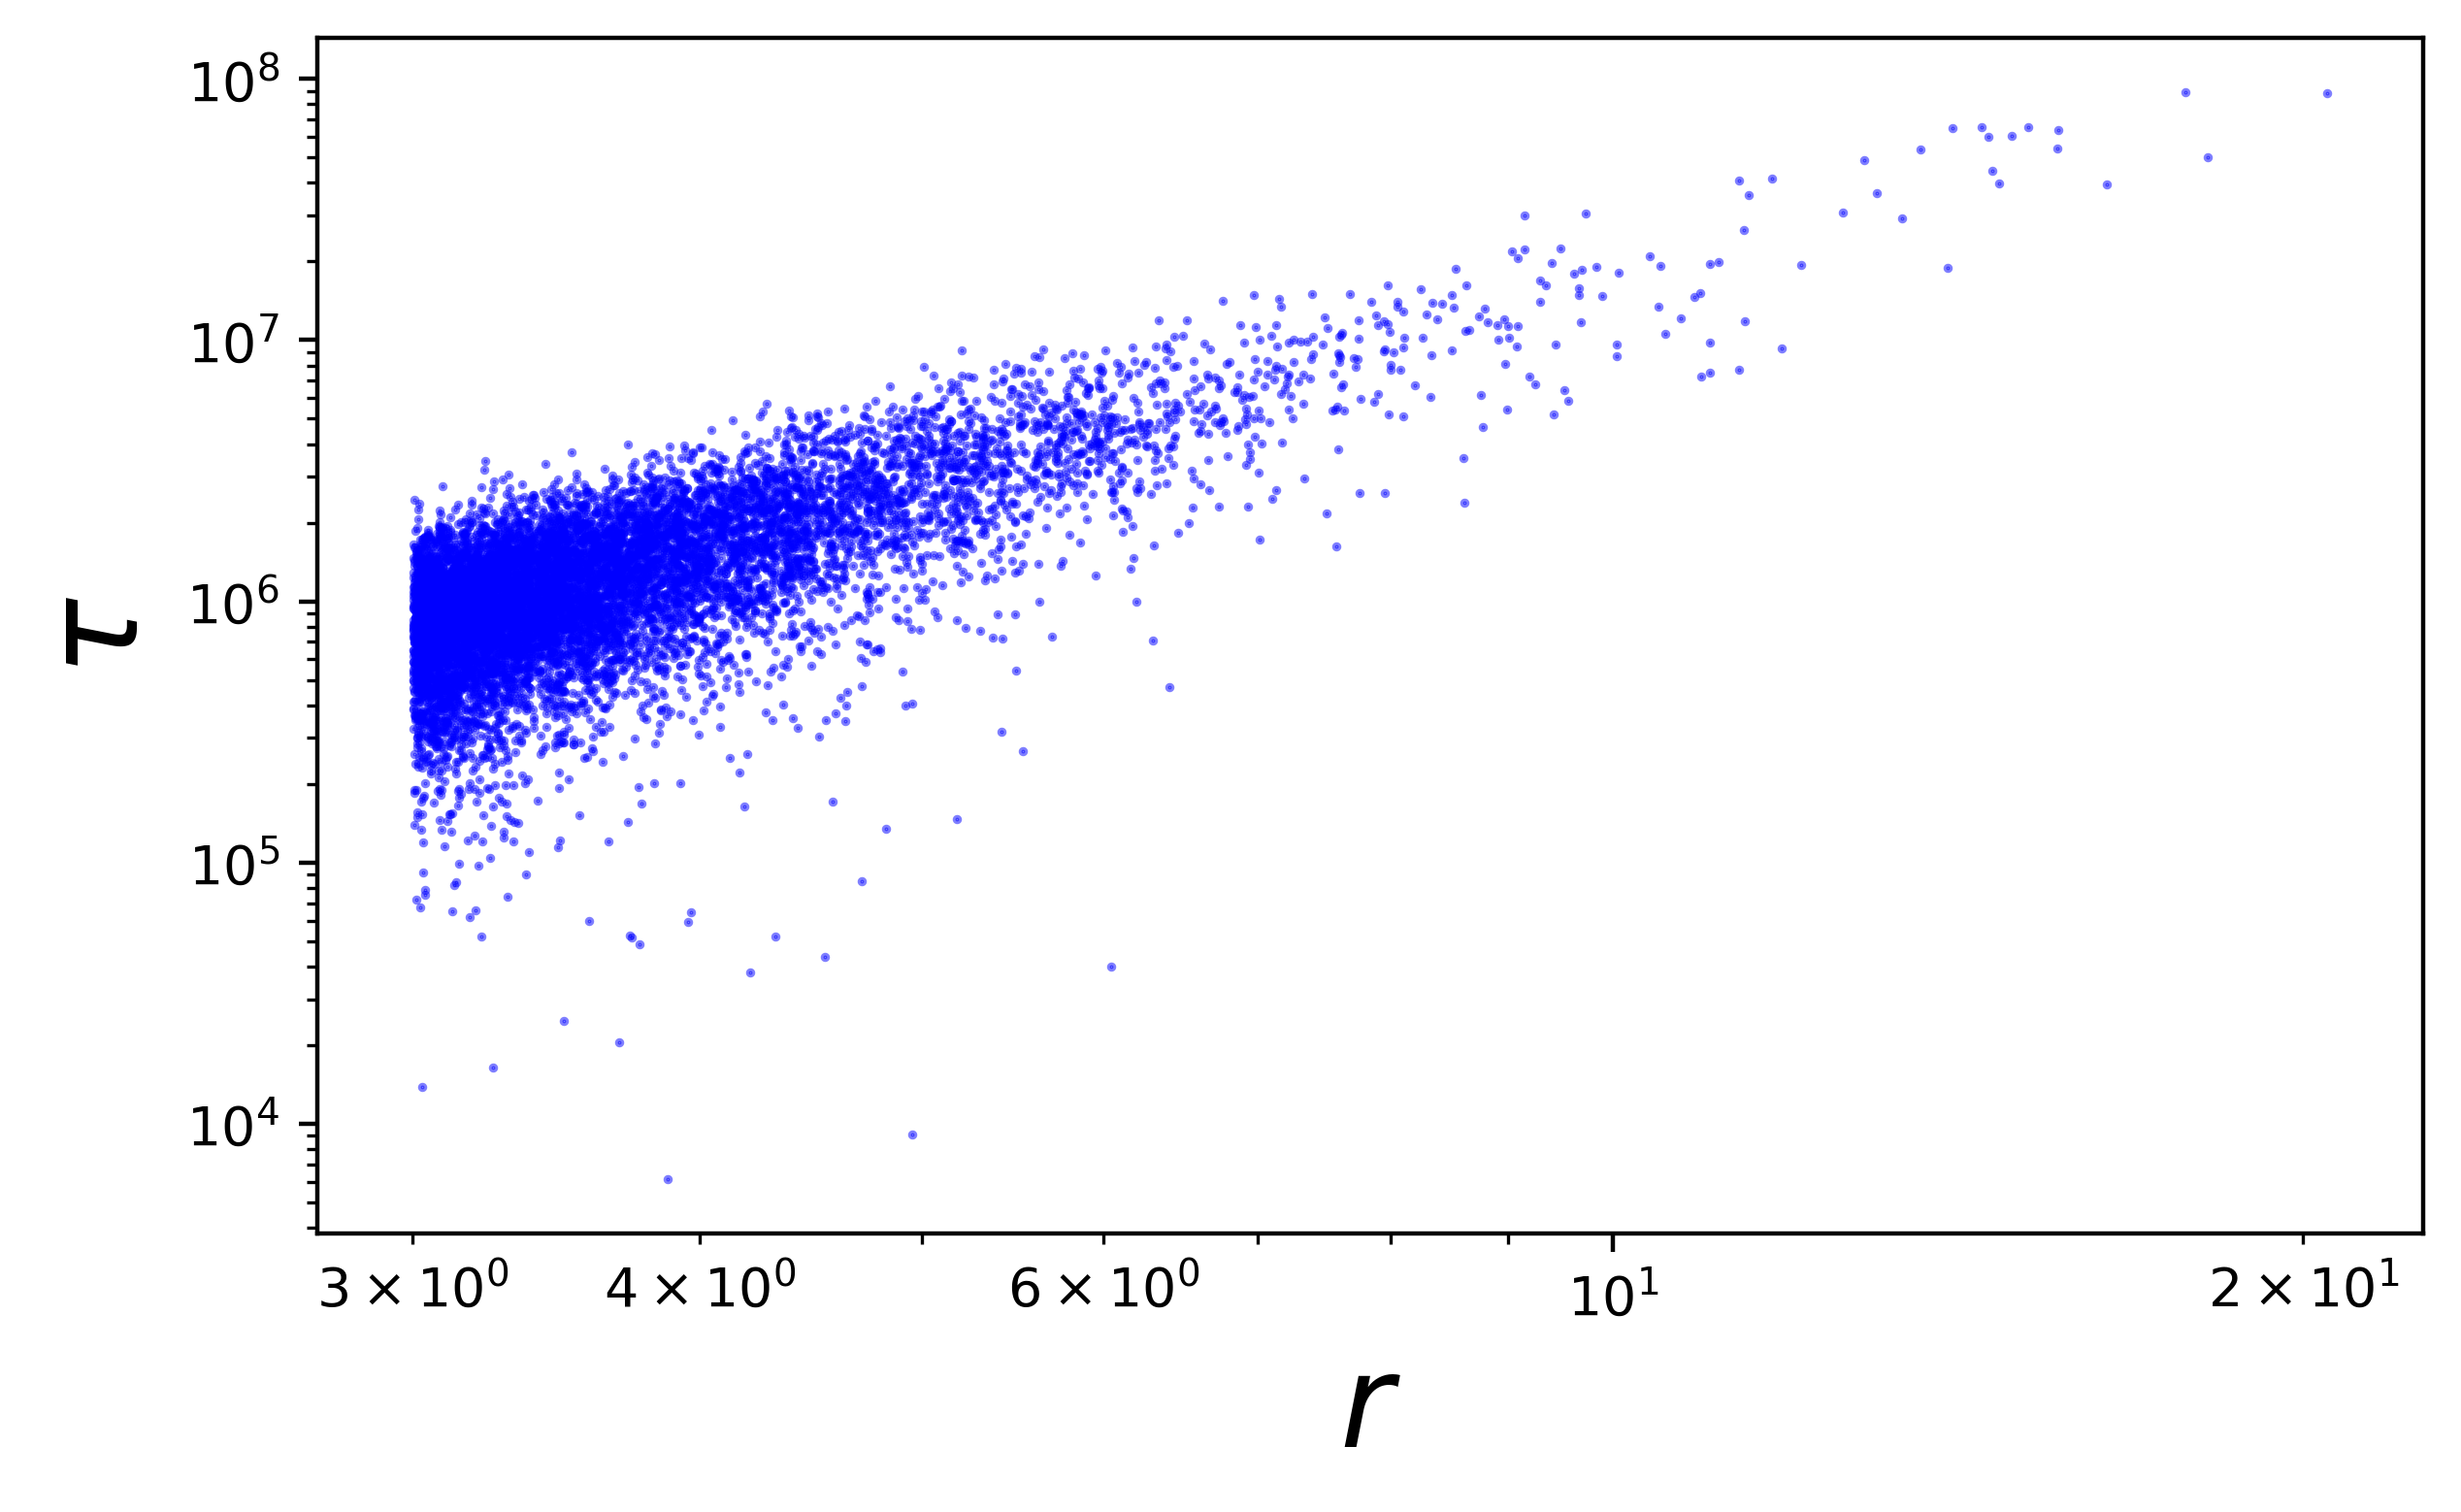

In [14]:
plt.figure(figsize=(7, 4), dpi=dpi)

sampled = df.sample(frac=0.1)

# Sampled scatterplot
plt.scatter(
    sampled.radius,
    sampled.lifespan,
    c="blue",
    s=.5,
    alpha=0.5
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("$r$", fontsize=font_size)
plt.ylabel(fr"$\tau$", fontsize=font_size)

plt.savefig(f"figures/example_lifetimes_scatter.svg", bbox_inches="tight")
plt.show()

In [43]:
model = smf.negativebinomial(data=df, formula="lifespan ~ 1 + np.log(radius)").fit(maxiter=1000, method="BFGS", cov_type="HC0")
print(model.summary())

Optimization terminated successfully.
         Current function value: 14.737818
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
                     NegativeBinomial Regression Results                      
Dep. Variable:               lifespan   No. Observations:               999967
Model:               NegativeBinomial   Df Residuals:                   999965
Method:                           MLE   Df Model:                            1
Date:                Sat, 22 Feb 2025   Pseudo R-squ.:                 0.03929
Time:                        19:35:29   Log-Likelihood:            -1.4737e+07
converged:                       True   LL-Null:                   -1.5340e+07
Covariance Type:                  HC0   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         10.8458     

In [44]:
# Dispersion statistic
np.sum(model.resid_pearson**2) / model.df_resid

0.9180557942226907